In [1]:
from sklearn.datasets import make_regression
from sklearn.feature_selection import f_regression, r_regression, mutual_info_regression
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

## 1. Medidas de relevancia para regresión

### 1.1. Coeficiente de correlación de Pearson

Ejemplo de atributo relevante, altamente correlacionado con la variable objetivo:

In [2]:
x, t = make_regression(n_samples=50, n_features=1, n_informative=1, noise=50.)
model = LinearRegression().fit(x, t)
a = model.coef_[0]
b = model.intercept_

In [3]:
xline = np.array([x.min(), x.max()])
yline = a * xline + b
rho = r_regression(x, t)

In [4]:
rho

array([0.70712141])

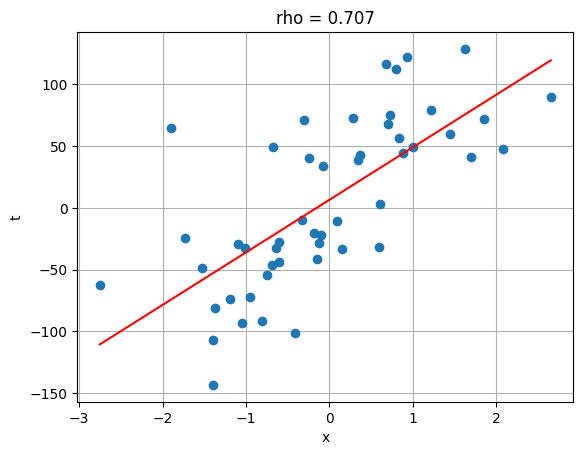

In [5]:
plt.figure()
plt.plot(x, t, 'o')
plt.plot(xline, yline, 'r-')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('t')
plt.title(f'rho = {rho[0]:.3f}')
plt.savefig('corr_pos_3.png')
plt.show()

Coeficiente de correlación de Pearson calculado manualmente:

In [6]:
r = np.cov(np.concatenate((x, t[:, None]), axis=1).transpose())
r

array([[1.26659337e+00, 5.38610176e+01],
       [5.38610176e+01, 4.58061638e+03]])

In [7]:
rho = r[0, 1] / np.sqrt(r[0, 0] * r[1, 1])
rho

np.float64(0.7071214108754833)

Otra forma de hacerlo:

In [8]:
r2 = model.score(x, t)
rho = np.sqrt(r2)
rho

np.float64(0.7071214108754834)

### 1.2. Test F de Fisher

In [9]:
f_statistic, p_values = f_regression(x, t)
f_statistic

array([48.00397259])

In [10]:
p_values

array([9.46472659e-09])

Hagamos ahora el F-test manualmente también:

In [11]:
N, K = x.shape
fstat = (r2/(1-r2))*((N-K-1)/K)
fstat

48.003972590342116

In [12]:
from scipy.stats import f

In [13]:
f.sf(fstat, K, N-K-1) # Esto es la survival function, definida como 1 - cdf, pero más precisa...

np.float64(9.46472659410771e-09)

### 1.3. Información mutua

In [14]:
mutual_info_regression(x, t)

array([0.33498329])

### 1.4. Selección de atributos

Generamos un problema de regresión y obtenemos las relevancias de cada atributo con cada uno de los métodos anteriores.

In [15]:
x, t = make_regression(n_samples=500, n_features=10, n_informative=7, noise=10.)
print(x.shape)
print(t.shape)

(500, 10)
(500,)


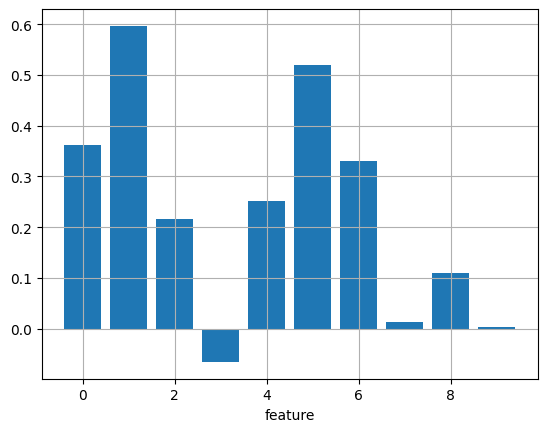

In [16]:
relevance = r_regression(x, t)
plt.figure()
plt.bar(np.arange(x.shape[1]), relevance)
plt.grid(True)
plt.xlabel('feature')
plt.show()

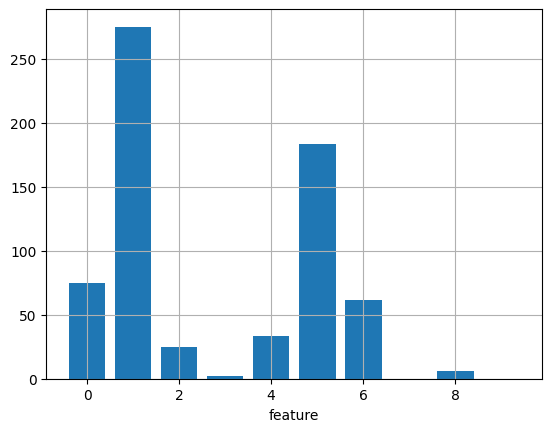

In [17]:
relevance = f_regression(x, t)[0]
plt.figure()
plt.bar(np.arange(x.shape[1]), relevance)
plt.grid(True)
plt.xlabel('feature')
plt.show()

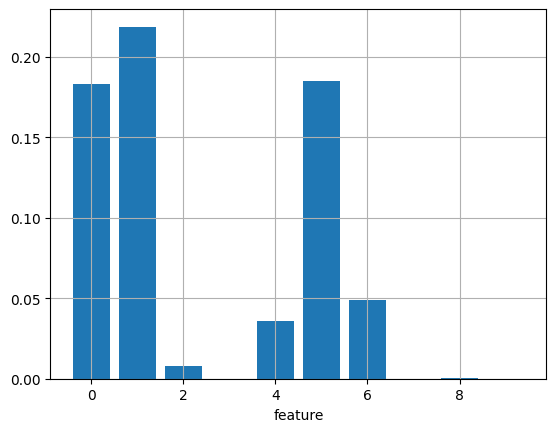

In [18]:
relevance = mutual_info_regression(x, t)
plt.figure()
plt.bar(np.arange(x.shape[1]), relevance)
plt.grid(True)
plt.xlabel('feature')
plt.show()

### 1.5. Comparación entre F_regression e información mutua

Basado en https://scikit-learn.org/stable/auto_examples/feature_selection/plot_f_test_vs_mi.html#sphx-glr-auto-examples-feature-selection-plot-f-test-vs-mi-py

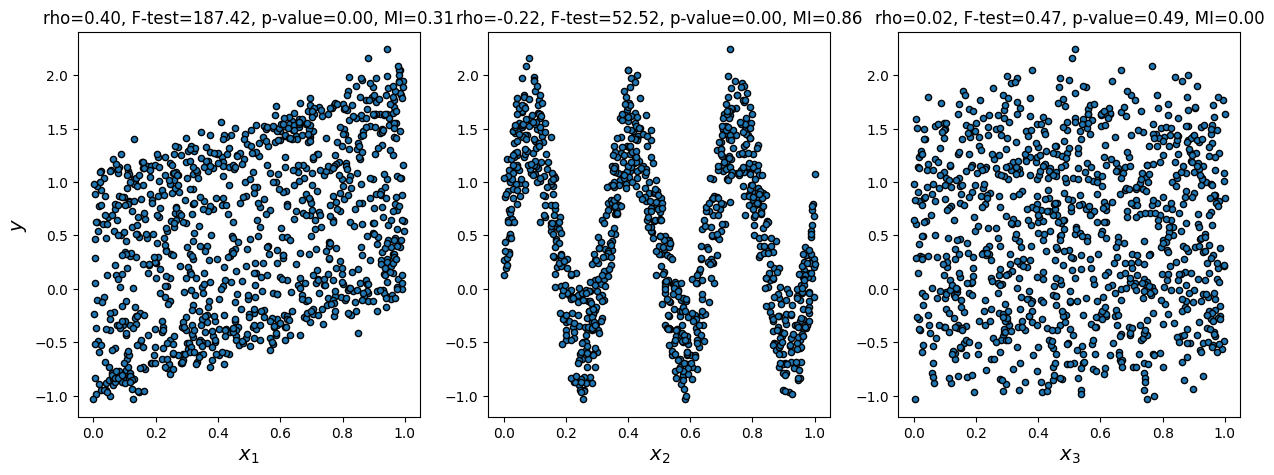

In [19]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_selection import f_regression, mutual_info_regression

np.random.seed(0)
X = np.random.rand(1000, 3)
y = X[:, 0] + np.sin(6 * np.pi * X[:, 1]) + 0.1 * np.random.randn(1000)

rho = r_regression(X, y)
f_test, p_value = f_regression(X, y)
mi = mutual_info_regression(X, y)

plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.scatter(X[:, i], y, edgecolor="black", s=20)
    plt.xlabel("$x_{}$".format(i + 1), fontsize=14)
    if i == 0:
        plt.ylabel("$y$", fontsize=14)
    plt.title("rho={:.2f}, F-test={:.2f}, p-value={:.2f}, MI={:.2f}".format(rho[i], f_test[i], p_value[i], mi[i]))
plt.show()

## 2. Medidas de relevancia para clasificación

### 2.1. F-test para clasificación

In [20]:
from sklearn.datasets import make_classification
from sklearn.feature_selection import f_classif

x, y = make_classification(
    n_samples=100, n_features=5, n_informative=3, n_clusters_per_class=1,
    shuffle=False, random_state=42
)

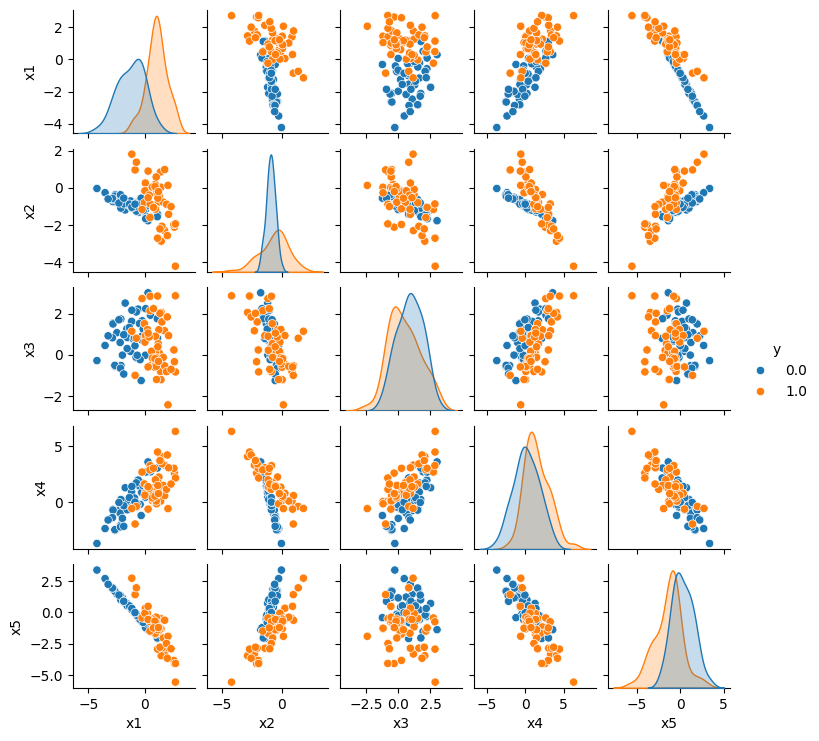

In [21]:
import seaborn
import pandas as pd

seaborn.pairplot(pd.DataFrame(np.concatenate((x, y[:, None]), axis=1), columns=['x1', 'x2', 'x3', 'x4', 'x5', 'y']), hue='y', height=1.5)
plt.savefig('pairplot.png')
plt.show()

In [22]:
f_statistic, p_values = f_classif(x, y)
print(f_statistic)
print(p_values)

[114.35894871   2.49497931   3.48796029  17.66460425  34.49416309]
[3.79832813e-18 1.17432301e-01 6.48050559e-02 5.82179120e-05
 5.86545864e-08]


Orden en el que se seleccionan los atributos:

In [23]:
np.argsort(-f_statistic)

array([0, 4, 3, 2, 1])

Calculemos manualmente el valor del estadístico:

In [24]:
m = np.mean(x, axis=0)
n = x.shape[0]
ix0 = np.where(y == 0)[0]
ix1 = np.where(y == 1)[0]
n0 = ix0.shape[0]
n1 = ix1.shape[0]
k = 2 # número de clases
m0 = np.mean(x[ix0, :], axis=0)
m1 = np.mean(x[ix1, :], axis=0)

In [25]:
inter = n0 * (m0 - m)**2 + n1 * (m1 - m)**2
intra = np.sum((x[ix0, :] - m0)**2, axis=0) + np.sum((x[ix1, :] - m1)**2, axis=0)
fstat = (inter / (k - 1)) / (intra / (n - k))
fstat

array([114.35894871,   2.49497931,   3.48796029,  17.66460425,
        34.49416309])

In [26]:
f.sf(fstat, k - 1, n - k)

array([3.79832813e-18, 1.17432301e-01, 6.48050559e-02, 5.82179120e-05,
       5.86545864e-08])

### 2.1. Información mutua

In [27]:
from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(x, y)

Orden en el que se seleccionan los atributos:

In [28]:
np.argsort(-mi)

array([0, 1, 4, 3, 2])

## 3. Métodos de tipo wrapper

Basado en https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py

In [29]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

Correlaciones entre los atributos:

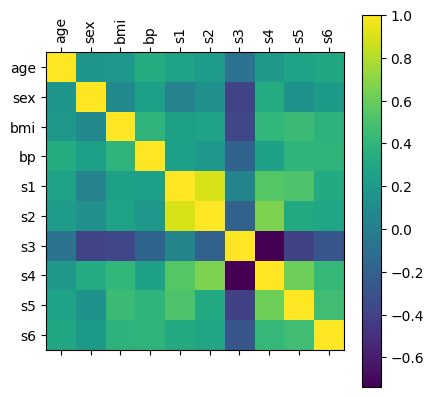

In [30]:
plt.matshow(np.corrcoef(X.T))
plt.xticks(np.arange(X.shape[1]), diabetes.feature_names, rotation=90)
plt.yticks(np.arange(X.shape[1]), diabetes.feature_names)
plt.colorbar()
plt.show()

### 3.1. Relevancia basada en un modelo

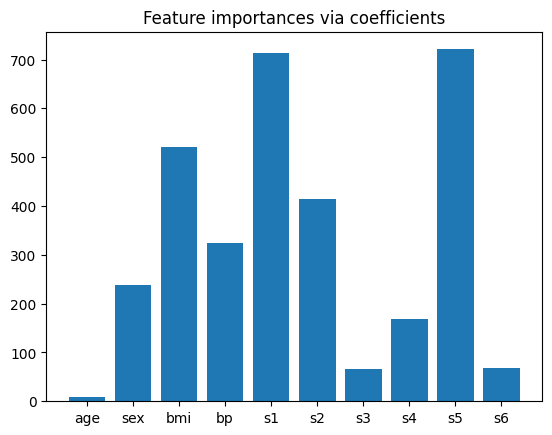

In [31]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X, y)
importance = np.abs(ridge.coef_) # La importancia es el valor absoluto de los coeficientes de la regresión!!!
feature_names = np.array(diabetes.feature_names)
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.show()

In [32]:
from time import time

from sklearn.feature_selection import SelectFromModel

threshold = np.sort(importance)[-3] + 0.01

tic = time()
sfm = SelectFromModel(ridge, threshold=threshold).fit(X, y)
toc = time()
print(f"Features selected by SelectFromModel: {feature_names[sfm.get_support()]}")
print(f"Done in {toc - tic:.3f}s")

Features selected by SelectFromModel: ['s1' 's5']
Done in 0.002s


### 3.2. FW selection y BW elimination

In [33]:
from sklearn.feature_selection import SequentialFeatureSelector

tic_fwd = time()
sfs_forward = SequentialFeatureSelector(
    ridge, n_features_to_select=2, direction="forward"
).fit(X, y)
toc_fwd = time()

tic_bwd = time()
sfs_backward = SequentialFeatureSelector(
    ridge, n_features_to_select=2, direction="backward"
).fit(X, y)
toc_bwd = time()

print(
    "Features selected by forward sequential selection: "
    f"{feature_names[sfs_forward.get_support()]}"
)
print(f"Done in {toc_fwd - tic_fwd:.3f}s")
print(
    "Features selected by backward sequential selection: "
    f"{feature_names[sfs_backward.get_support()]}"
)
print(f"Done in {toc_bwd - tic_bwd:.3f}s")

Features selected by forward sequential selection: ['bmi' 's5']
Done in 0.062s
Features selected by backward sequential selection: ['bmi' 's5']
Done in 0.186s


### 3.3. Importancia por permutación

In [34]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
diabetes = load_diabetes()
X_train, X_val, y_train, y_val = train_test_split(
    diabetes.data, diabetes.target, random_state=0)

model = Ridge(alpha=1e-2).fit(X_train, y_train)
model.score(X_val, y_val)

0.3566675322939423

In [35]:
from sklearn.inspection import permutation_importance
r = permutation_importance(model, X_val, y_val,
                           n_repeats=30,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    print(f"{diabetes.feature_names[i]:<8}"
          f"{r.importances_mean[i]:.3f}"
          f" \u00B1 {r.importances_std[i]:.3f}")

s5      0.204 ± 0.050
bmi     0.176 ± 0.048
bp      0.088 ± 0.033
sex     0.056 ± 0.023
s1      0.042 ± 0.031
s4      0.003 ± 0.008
s6      0.003 ± 0.003
s3      0.002 ± 0.013
s2      0.002 ± 0.003
age     -0.002 ± 0.004
